### PWC without Mixup
Prior to this, I used mixup during the initial fine-tuning, PWC was only introduced a little after that. What if we don't use mixup at all during finetuning and use PWC?

In [1]:
from fastai.vision import *
from fastai.utils.ipython import * 

In [2]:
from fastai.callbacks.tracker import *

In [3]:
import pickle
with open('labels.pkl','rb') as f:
    labels = pickle.load(f)
path = Path('./')

In [4]:
seed = 42
src = (ImageList
       .from_folder(path,include='cars_train',extensions='.jpg')
       .split_by_rand_pct(0.15,seed=42)
       .label_from_func(lambda x: labels[x.name])
      )

In [ ]:
data = (src
        .transform(get_transforms(),size=(299,299))
        .databunch(bs=40)
        .normalize(imagenet_stats)
       )

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


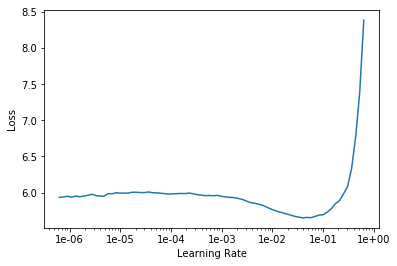

In [7]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.984015,5.197425,0.081900,02:18
1,2.417280,1.914654,0.486486,02:15
2,1.336962,1.130045,0.700246,02:16


In [9]:
learn.save('pwc_no_mixup1')

In [10]:
learn.unfreeze()
learn.fit_one_cycle(3,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.646321,1.878992,0.496314,02:57
1,1.117423,0.912132,0.732187,02:57
2,0.596506,0.596420,0.832924,02:57


In [11]:
learn.fit_one_cycle(4,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.821587,1.545323,0.567568,02:57
1,0.922115,0.831304,0.772318,02:56
2,0.508858,0.489035,0.850942,02:56
3,0.300981,0.409101,0.883702,02:56


In [12]:
learn.save('pwc_no_mixup2');

In [11]:
learn.load('pwc_no_mixup2');

The model seems pretty competent now, let's introduce PairWise Confusion.

In [8]:
class PWCLoss():
    def __init__(self,l=1):
        self.l = l
        self.train = True
    def __call__(self,inp,targ,reduction=None):

        loss = FlattenedLoss(CrossEntropyFlat)(inp,targ)
        if self.train:
            if(len(inp)%2!=0):
                return loss
            inp1, inp2 = inp.chunk(2,0)
            targ1, targ2 = targ.chunk(2)
            mask = (targ1 != targ2).float()
            bs = len(inp1)
            pwc = torch.zeros(bs).cuda()
            for i in range(bs):
                pwc[i] = torch.dist(inp1[i],inp2[i]).cuda()
            pwc = self.l * pwc * mask / bs
            return loss + pwc.mean()
        else:
            return loss

In [9]:
learn.loss_func = PWCLoss()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-5,5e-4))

In [16]:
learn.save('pwc_no_mixup3');

In [17]:
learn.fit_one_cycle(5,slice(1e-5,5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.142759,1.974353,0.906634,02:58
1,2.074761,1.905728,0.882064,02:59
2,1.940093,1.774175,0.900901,02:59
3,1.802159,1.711525,0.908272,03:00
4,1.756239,1.699826,0.909910,03:00


In [18]:
learn.save('pwc_no_mixup4');

In [19]:
learn.fit_one_cycle(10,slice(5e-6,5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.742849,1.684807,0.906634,03:00
1,1.742824,1.663112,0.909910,02:59
2,1.698816,1.627332,0.907453,03:00
3,1.635134,1.591342,0.909910,03:01
4,1.559197,1.533808,0.913186,03:01
5,1.488045,1.494487,0.904996,02:59
6,1.437563,1.454596,0.923833,02:59
7,1.405286,1.434353,0.923833,03:00
8,1.382075,1.424019,0.919738,02:58
9,1.374686,1.421180,0.923014,02:59


In [27]:
learn.save('pwc_no_mixup5_923');

In [39]:
learn.load('pwc_no_mixup5_923'); 
learn.unfreeze()

In [40]:
learn.fit_one_cycle(10,slice(5e-6,5e-4),callbacks=[SaveModelCallback(learn,every='improvement',monitor='accuracy',name='pwc_final_model')])

epoch,train_loss,valid_loss,accuracy,time
0,1.373969,1.418474,0.921376,02:59
1,1.373405,1.413441,0.915643,03:00
2,1.382981,1.439277,0.906634,03:00
3,1.347035,1.399223,0.908272,03:00
4,1.312729,1.366365,0.926290,02:59
5,1.264848,1.334578,0.927109,03:01
6,1.240465,1.310530,0.923014,03:00
7,1.217696,1.293922,0.926290,03:00
8,1.196453,1.289225,0.927928,02:59
9,1.181936,1.286527,0.928747,03:00


Better model found at epoch 0 with accuracy value: 0.9213759303092957.
Better model found at epoch 4 with accuracy value: 0.9262899160385132.
Better model found at epoch 5 with accuracy value: 0.9271089434623718.
Better model found at epoch 8 with accuracy value: 0.9279279112815857.
Better model found at epoch 9 with accuracy value: 0.9287469387054443.


In [9]:
learn.load('pwc_final_model');
learn.unfreeze();
learn.fit_one_cycle(10,slice(3e-6,3e-4),callbacks=[SaveModelCallback(learn,every='improvement',monitor='accuracy',name='pwc_final_model2')])

epoch,train_loss,valid_loss,accuracy,time
0,1.188681,1.286199,0.928747,03:05
1,1.184275,1.287866,0.925471,02:58
2,1.189429,1.286701,0.923014,02:58
3,1.174541,1.287730,0.926290,03:00
4,1.155334,1.261248,0.932842,02:59
5,1.144761,1.261479,0.927109,02:59
6,1.124920,1.243597,0.927928,02:58
7,1.116255,1.232555,0.930385,02:59
8,1.108173,1.229702,0.925471,02:57
9,1.101206,1.229123,0.927928,02:58


Better model found at epoch 0 with accuracy value: 0.9287469387054443.
Better model found at epoch 4 with accuracy value: 0.932841956615448.


The results are way better than before!

In [10]:
learn.load('pwc_final_model2');
learn.unfreeze();
learn.fit_one_cycle(10,slice(2e-6,2e-4),callbacks=[SaveModelCallback(learn,every='improvement',monitor='accuracy',name='pwc_final_model3')])

epoch,train_loss,valid_loss,accuracy,time
0,1.140655,1.249932,0.932023,03:05
1,1.136236,1.247232,0.926290,02:57
2,1.130416,1.258599,0.928747,02:58
3,1.121825,1.240763,0.932023,02:58
4,1.116591,1.238003,0.927928,02:59
5,1.102038,1.228082,0.927109,02:59
6,1.091816,1.224931,0.926290,02:58
7,1.090135,1.216844,0.930385,03:00
8,1.077382,1.215858,0.928747,02:59
9,1.079707,1.215610,0.930385,02:59


Better model found at epoch 0 with accuracy value: 0.9320229291915894.


# Inference

In [15]:
learn.load('pwc_final_model3');

In [16]:
#set the path of the folder containing test images
path = Path('/test')
test_imgs = path.ls()
test_imgs.sort(key=lambda x: x.stem)

In [17]:
#Add test data to the databunch and assign it to the learner.
data.add_test(test_imgs) 
learn.data = data

tensor(0.9292)

In [ ]:
res = learn.TTA(ds_type=DatasetType.Test,with_loss=True)
preds = res[0].argmax(-1)